# Mounting the Drive.

In [ ]:
#MOUNT DRIVE
import tensorflow as tf
from google.colab import files, drive
drive.mount("/content/drive")
folder_path = '/content/drive/My Drive/MURA/MURA-v1.1/'
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name) +",  tf version: "+str(tf.__version__))

Mounted at /content/drive
Found GPU at: /device:GPU:0,  tf version: 2.15.0


# Importing Necessary Libraries.

In [ ]:
!pip install livelossplot --quiet
!pip install opencv-python --quiet
from livelossplot import PlotLossesKeras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.applications import InceptionV3
from keras import Input
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D,Add
from keras.layers import Activation, Dropout, Flatten, Dense, Dot, Softmax,Concatenate
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

from keras.utils import plot_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from random import randint
from IPython.display import Image
import matplotlib.cm as cma
%matplotlib inline


# Initialize the different categories that we will have to Classify.

In [ ]:
study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']

# Useful Functions for our data preproccecing.

In [ ]:
def listdir_nohidden(path):
    '''
    Utility function to find the list of files in a directory excluding the hidden files.
    Args:
        path: contains the path of the directory containing the images

    '''
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [ ]:

%cd /content/drive/MyDrive/MURA


/content/drive/MyDrive/MURA


In [ ]:
def create_images_metadata_csv(category, study_types):
    '''
    This function creates a csv file containing the path of images, label.
    Args:
        category: train or valid, depending on which csv is needed
        study_types: the type of the body part in MURA Dataset, eg:  XR_SHOULDER
    '''

    image_data = {}
    study_label = {'positive': 1, 'negative': 0}

    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label','Type'])
    for study_type in study_types: # Iterate through every study type
        DATA_DIR = 'MURA-v1.1/%s/%s/' % (category, study_type)
        patients = os.listdir(DATA_DIR)  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if study != '.DS_Store':
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(os.listdir(path))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path, 1, label, study_type]  # add new row
                        i += 1

    image_data[category].to_csv(category + "_image_data.csv", index=None, header=False)
    print(f"{category}_image_data.csv created successfully.")


# Downloading the Dataset Directly to the Drive.

In [ ]:
import os
import tensorflow as tf

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify destination directory on Google Drive
drive_dataset_dir = "/content/drive/My Drive/MURA/"

# Check if the directory exists, if not create it
if not os.path.isdir(drive_dataset_dir):
    os.makedirs(drive_dataset_dir)

# Download the dataset and save it to Google Drive
if not os.path.isdir(os.path.join(drive_dataset_dir, "MURA-v1.1")):
    dataset_url = "https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip"
    tf.keras.utils.get_file("MURA-v1.1.zip", dataset_url, extract=True, archive_format='zip', cache_dir='/content/drive/My Drive/MURA/', cache_subdir='.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Images to Drive as CSV.

In [ ]:
#TRAIN DATA
create_images_metadata_csv('train',study_types)
#VALID DATA
create_images_metadata_csv('valid',study_types)

100%|██████████| 3267/3267 [00:31<00:00, 104.27it/s]


train_image_data.csv created successfully.


100%|██████████| 207/207 [00:39<00:00,  5.22it/s]

valid_image_data.csv created successfully.


# Read the images and create dataframes that contain the paths of the pictures that will constitute our Train and Validation Sets.

In [ ]:
valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label','Type'])
train_image_df = pd.read_csv('train_image_data.csv', names=['Path', 'Count','Label','Type'])

dd={}

dd['train'] = train_image_df
dd['valid'] = valid_image_df


# Invastigating Train Data.

We can see that with the exception of the hand. Our positive to negative ratio is balanced between Types.

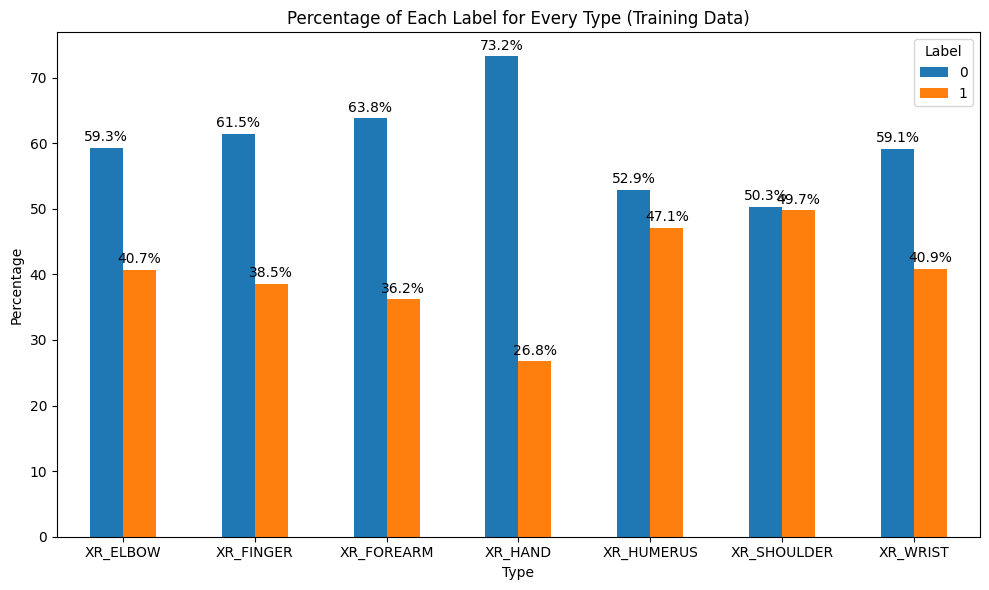

In [ ]:
# Group the data by "Type" and "Label" and calculate the counts

grouped_data = dd['train'].groupby(["Type", "Label"])['Count'].sum().reset_index()

# Pivot the table to get counts of each label for every type
pivot_table = pd.pivot_table(grouped_data, values='Count', index='Type', columns='Label', fill_value=0)

# Calculate the percentage of each label for every type
percentages = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plotting the percentages
ax = percentages.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Percentage of Each Label for Every Type (Training Data)')
plt.xlabel('Type')
plt.ylabel('Percentage')
plt.legend(title='Label', loc='upper right')

# Adding annotations with increased space
annotation_space = 1
# Adjust this value to increase or decrease space
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height + annotation_space), ha='center')

plt.xticks(rotation=0)  # Adjust rotation as needed
plt.tight_layout()

plt.show()

# Investigating Validation Data.

Our validation data are more balanced when it comes to the positive to negative ratio compared to our training data.

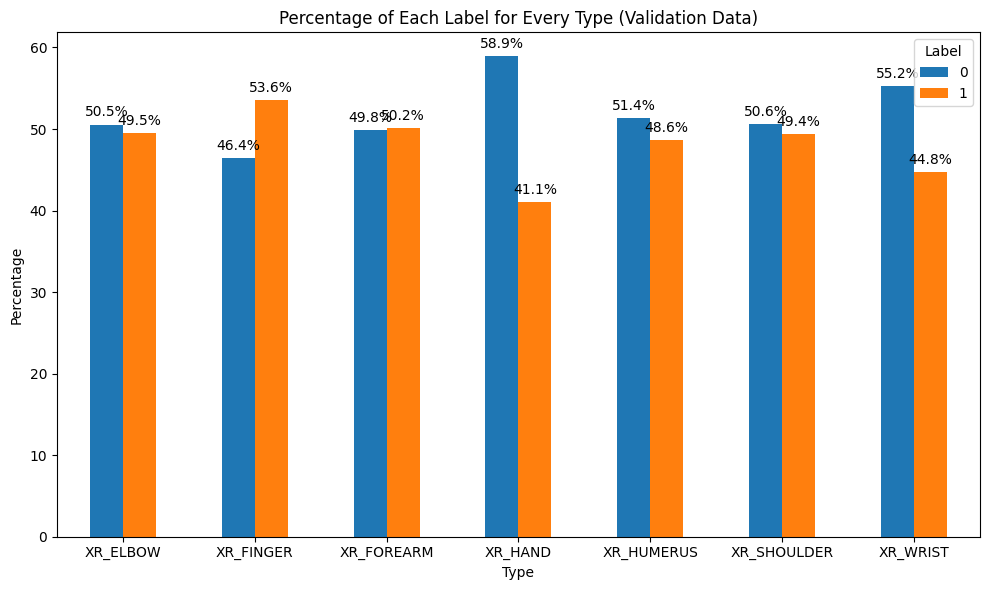

In [ ]:
# Group the data by "Type" and "Label" and calculate the counts
grouped_data = dd['valid'].groupby(["Type", "Label"])['Count'].sum().reset_index()

# Pivot the table to get counts of each label for every type
pivot_table = pd.pivot_table(grouped_data, values='Count', index='Type', columns='Label', fill_value=0)

# Calculate the percentage of each label for every type
percentages = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Plotting the percentages
ax = percentages.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Percentage of Each Label for Every Type (Validation Data)')
plt.xlabel('Type')
plt.ylabel('Percentage')
plt.legend(title='Label', loc='upper right')

# Adding annotations with increased space
annotation_space = 1
# Adjust this value to increase or decrease space
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height + annotation_space), ha='center')

plt.xticks(rotation=0)  # Adjust rotation as needed
plt.tight_layout()

plt.show()

# Creating our Training,Validation and Test Arrays.

We create a fuction that reads the dataframes that contain the training and validation sets and filters for only one category that we wish to study, Creates a Test set and for all of those, using the image paths, it constructs our train,validation and test arrays.

In [ ]:
def preprocess_MURA_dataset(X_train,X_Valid,Type=None):


    if Type:
        # Filter Your Data Based on a Type
        train_df = X_train[dd['train']['Type'] == Type]
        valid_df = X_Valid[dd['valid']['Type'] == Type]


    # Make the labels strings because the task is binary
    train_df.loc[:, 'Label'] = ['positive' if x==1 else "negative" for x in train_df['Label']]
    valid_df.loc[:, 'Label'] = ['positive' if x==1 else "negative" for x in valid_df['Label']]

    train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42)

    #Create Data Generator that Augments the Train Data
    idg_train_params = dict(samplewise_center = True,
                        samplewise_std_normalization = True,
                        rotation_range = 30,
                        width_shift_range = 0.15,
                        height_shift_range = 0.15,
                        zoom_range = 0.1,
                        horizontal_flip = True,
                        vertical_flip = True
                        )

    idg_train = ImageDataGenerator(**idg_train_params)

    # Load the Augmented Training Data
    train_generator = idg_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='Path',
    y_col='Label',
    batch_size=32,
    shuffle=True,
    class_mode="binary",  # binary classification
    target_size=(320, 320),
    color_mode='rgb'
    )

    #Create Data Generator that helps with the loading of the Validation Data
    idg_valid_params = dict(samplewise_center = True,
                        samplewise_std_normalization = True,
                        rotation_range = 0,
                        width_shift_range = 0.,
                        height_shift_range = 0.,
                        zoom_range = 0.0,
                        horizontal_flip = False,
                        vertical_flip = False)
    idg_valid = ImageDataGenerator(**idg_valid_params)

    # Load the Augmented Validation Data
    valid_generator = idg_valid.flow_from_dataframe(
        dataframe=valid_df,
        x_col='Path',
        y_col='Label',
        batch_size=32,
        shuffle=True,
        class_mode="binary",  # binary classification
        target_size=(320, 320),
        color_mode='rgb'
    )

    #Create Data Generator that helps with the loading of the Test Data
    test_valid_params = dict(samplewise_center = True,
                        samplewise_std_normalization = True,
                        rotation_range = 0,
                        width_shift_range = 0.,
                        height_shift_range = 0.,
                        zoom_range = 0.0,
                        horizontal_flip = False,
                        vertical_flip = False)
    test_valid = ImageDataGenerator(**test_valid_params)

    # Load the Augmented Test Data
    test_generator = test_valid.flow_from_dataframe(
        dataframe=test_df,
        x_col='Path',
        y_col='Label',
        batch_size=32,
        shuffle=True,
        class_mode="binary",  # binary classification
        target_size=(320, 320),
        color_mode='rgb'
    )

    return(train_generator,valid_generator,test_generator)

In [ ]:
from sklearn.model_selection import train_test_split
train_gen,val_gen,test_gen=preprocess_MURA_dataset(dd['train'],dd['valid'],Type= 'XR_WRIST')

train_step_size = math.ceil(train_gen.n / train_gen.batch_size)
valid_step_size = math.ceil(val_gen.n / val_gen.batch_size)
test_step_size = math.ceil(test_gen.n / test_gen.batch_size)

<ipython-input-8-ccb0b5ae2d99>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'Label'] = ['positive' if x==1 else "negative" for x in train_df['Label']]
<ipython-input-8-ccb0b5ae2d99>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df.loc[:, 'Label'] = ['positive' if x==1 else "negative" for x in valid_df['Label']]


Found 8776 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(


Found 659 validated image filenames belonging to 2 classes.
Found 976 validated image filenames belonging to 2 classes.


# Create functions to be used in our Neural networks, or to be used to visualize results.  

In [ ]:
def plot_history(hs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)

    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'AUC')
    plt.legend()
    plt.show()

In [ ]:
def callbacks():
    return [
        EarlyStopping(monitor = 'val_accuracy', patience = 6,restore_best_weights=True),
        ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3),
        ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    ]

# Creating our first CNN Without using pre trained models.

We create an CNN that starts With 4 convolutions, all of them have kernel size (3,3) but 2 of them have strides (2,2) while the other two have dilation (2,2) to get both the benefits of the stride and the dilation. We do BatchNormalazation before each maxpooling, and we add a dropout layer to help avoid overfitting. Finally we flatten the output and pass it through some dense layers. Since our problem is binary, we use at the last dense layer the sigmoid activation function and the metric we try to optimize is the b inary cross entropy. You can observe that our filters are very small, because we have RBG images and when we iventually flatten them we will not be able to use a dense mlp with more than 10 units because of memory restrictions.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Dropout, TimeDistributed, Flatten, Bidirectional, GRU, Dense
from tensorflow.keras.models import Model
import numpy as np
import tensorflow as tf


def Custom_CNN(optimizer=SGD, input_shape=(320, 320, 3), lr=0.1, filters=[4,6,6, 9], mlp_layers=[1024, 1],activation='relu', reg=regularizers.l2(0.01), drop_conv=0.2):
    # Define the optimizer with the given learning rate
    optimizer = optimizer(lr)

    np.random.seed(1402)  # Define the seed for numpy to have reproducible experiments.
    tf.random.set_seed(1981)  # Define the seed for TensorFlow to have reproducible experiments.

    # Define the input layer.
    input = Input(shape=input_shape, name='Input')

    x = input

    for i, units in enumerate(filters):
      # Define the convolutional layers.
      x = Conv2D(filters=units, kernel_size=(3, 3), strides=((i+1)%2+1, (i+1)%2+1), padding='valid', dilation_rate=(1+i%2, 1+i%2), activation=activation, name='Conv2D-{0:d}'.format(i))(x)
      x = BatchNormalization()(x)
      x = Activation('relu', name='Activation-{0:d}'.format(i))(x)
      x = MaxPooling2D((2, 2), name='MaxPool2D-{0:d}'.format(i))(x)
      x = Dropout(rate=drop_conv, name='Dropout-{0:d}'.format(i))(x)

    x = Flatten()(x)
    for i, units in enumerate(mlp_layers):
        if i == len(mlp_layers) - 1:
            activation = 'sigmoid'
        else:
            activation = 'relu'
        x = Dense(units=units, activation=activation, name=f'MLP-{i}-{activation}')(x)
    output=x
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
Custom_CNN().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 320, 320, 3)]     0         
                                                                 
 Conv2D-0 (Conv2D)           (None, 159, 159, 4)       112       
                                                                 
 batch_normalization (Batch  (None, 159, 159, 4)       16        
 Normalization)                                                  
                                                                 
 Activation-0 (Activation)   (None, 159, 159, 4)       0         
                                                                 
 MaxPool2D-0 (MaxPooling2D)  (None, 79, 79, 4)         0         
                                                                 
 Dropout-0 (Dropout)         (None, 79, 79, 4)         0         
                                                             

In [ ]:
custom_model=Custom_CNN()
history = custom_model.fit(
                    train_gen,
                    validation_data=val_gen,
                    epochs=100,
                    verbose=1,
                    steps_per_epoch = train_step_size,
                    validation_steps=valid_step_size,
                    callbacks=callbacks(),
                    )

Epoch 1/100
275/275 [==============================] - 2618s 10s/step - loss: 0.6985 - accuracy: 0.5820 - val_loss: 0.7043 - val_accuracy: 0.5539 - lr: 0.1000
Epoch 2/100
275/275 [==============================] - 292s 1s/step - loss: 0.6710 - accuracy: 0.6021 - val_loss: 0.6829 - val_accuracy: 0.5827 - lr: 0.1000
Epoch 3/100
275/275 [==============================] - 297s 1s/step - loss: 0.6600 - accuracy: 0.6200 - val_loss: 0.6858 - val_accuracy: 0.5660 - lr: 0.1000
Epoch 4/100
275/275 [==============================] - 319s 1s/step - loss: 0.6513 - accuracy: 0.6304 - val_loss: 0.6737 - val_accuracy: 0.6009 - lr: 0.1000
Epoch 5/100
275/275 [==============================] - 329s 1s/step - loss: 0.6419 - accuracy: 0.6375 - val_loss: 0.6609 - val_accuracy: 0.6085 - lr: 0.1000
Epoch 6/100
275/275 [==============================] - 307s 1s/step - loss: 0.6549 - accuracy: 0.6256 - val_loss: 0.6635 - val_accuracy: 0.6176 - lr: 0.1000
Epoch 7/100
275/275 [==============================] - 3

Train Loss     : 0.63453
Validation Loss: 0.66818
Train Loss     : 0.62214
---
Train Accuracy     : 0.64631
Validation Accuracy: 0.59939
Test Accuracy      : 0.69672



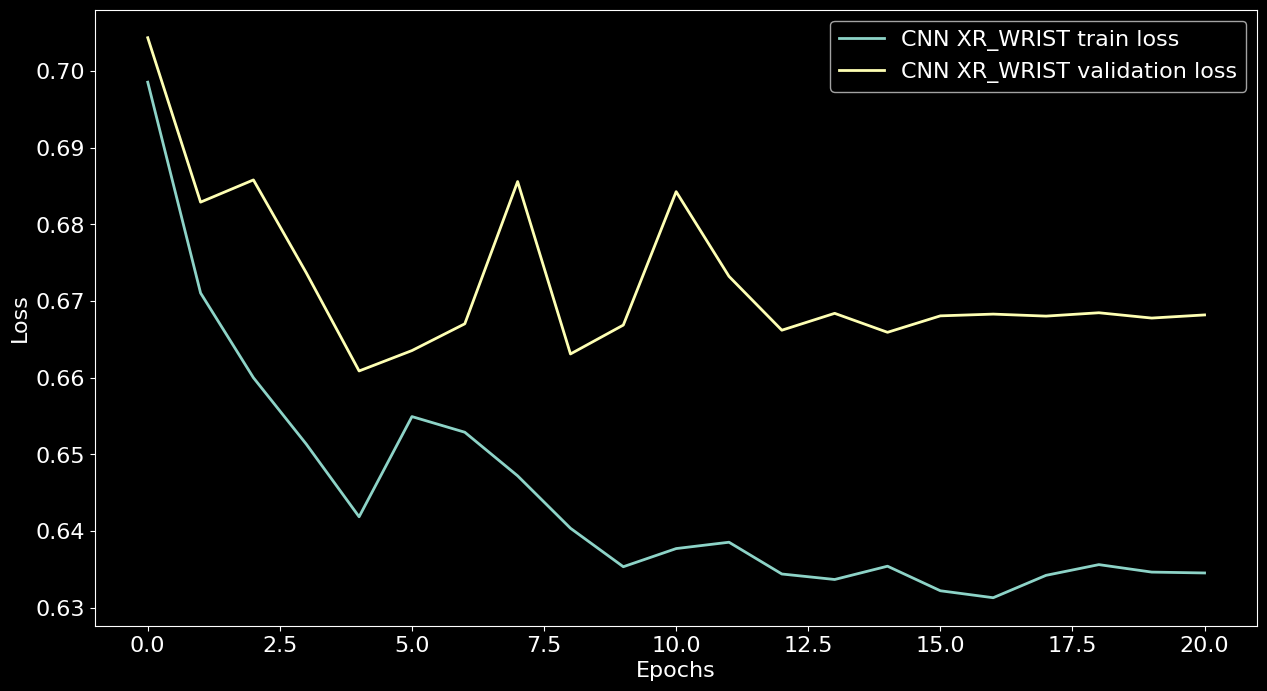

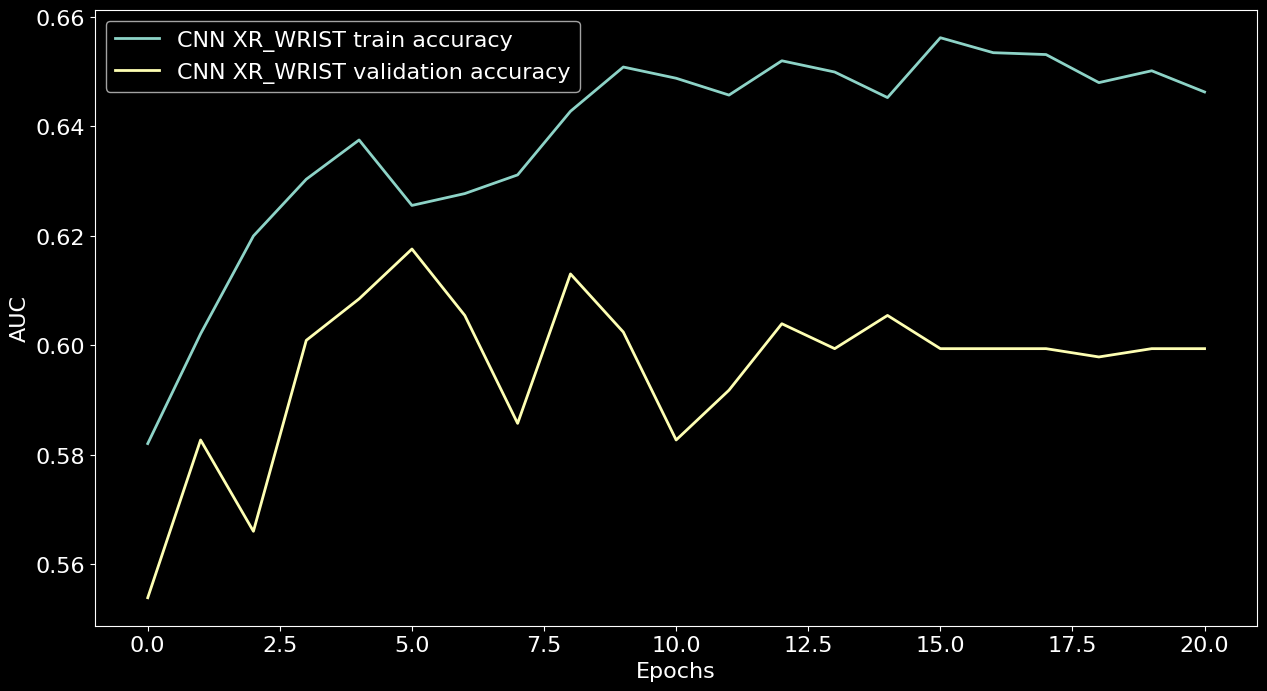

In [ ]:
custom_model_eval=custom_model.evaluate(test_gen)
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Train Loss     : {0:.5f}".format(custom_model_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(custom_model_eval[1]))
# Plot train and validation error per epoch.
plot_history(hs={'CNN XR_WRIST': history},  metric='loss' )
plot_history(hs={'CNN XR_WRIST': history},  metric='accuracy')

# Improving the previous CNN.

    __init__ method:
        Initializes the layer. It doesn't do much in this case, just calls the superclass __init__ method.

    build method:
        This method is called when the layer is built (i.e., when it is added to a model for the first time). It is used to create the layer's weights.
        It adds two weights:
            att_weight: A weight matrix used for computing attention scores.
            att_bias: A bias vector added to the attention scores.
        The weights are initialized with a normal distribution and zeros, respectively.

    call method:
        This method defines the computation performed by the layer.
        It computes attention scores (et) by applying a dense layer with tanh activation on the input tensor x.
        Softmax activation is applied to the attention scores to obtain attention weights (at).
        The attention weights are used to compute a weighted sum of the input tensor (output).
        Finally, it returns the weighted sum of the input tensor.

    compute_output_shape method:
        This method computes the shape of the layer's output tensor based on the shape of the input tensor.
        It returns the shape of the output tensor, which is the same as the input tensor except for the dimension being summed over.

    get_config method:
        This method returns the configuration of the layer.
        It calls the superclass get_config method to get the configuration.

Overall, this custom layer implements an attention mechanism that computes attention weights for the input tensor and returns a weighted sum of the input based on these attention weights.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

By adding a self attention Layer to our previous CNN, we cut the time of the training signifficantly while at the same time we increase validation accuracy by 5% and test accuracy by 7%.

In [ ]:
def Custom_CNN_self_attention(optimizer=SGD, input_shape=(320, 320, 3), lr=0.1, filters=[32,64,120], mlp_layers=[1024, 520],activation='relu', reg=regularizers.l2(0.01), drop_conv=0.2):
    # Define the optimizer with the given learning rate
    optimizer = optimizer(lr)

    np.random.seed(1402)  # Define the seed for numpy to have reproducible experiments.
    tf.random.set_seed(1981)  # Define the seed for TensorFlow to have reproducible experiments.

    # Define the input layer.
    input = Input(shape=input_shape, name='Input')

    x = input

    for i, units in enumerate(filters):
      # Define the convolutional layers.
      x = Conv2D(filters=units, kernel_size=(3, 3), strides=((i+1)%2+1, (i+1)%2+1), padding='valid', dilation_rate=(1+i%2, 1+i%2), activation=activation, name='Conv2D-{0:d}'.format(i))(x)
      x = BatchNormalization()(x)
      x = Activation('relu', name='Activation-{0:d}'.format(i))(x)
      x = MaxPooling2D((2, 2), name='MaxPool2D-{0:d}'.format(i))(x)
      x = Dropout(rate=drop_conv, name='Dropout-{0:d}'.format(i))(x)
    x=attention()(x)
    x = Flatten()(x)

    output=Dense(1,activation='sigmoid',trainable=True)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
Custom_CNN_self_attention().summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 320, 320, 3)]     0         
                                                                 
 Conv2D-0 (Conv2D)           (None, 159, 159, 32)      896       
                                                                 
 batch_normalization_42 (Ba  (None, 159, 159, 32)      128       
 tchNormalization)                                               
                                                                 
 Activation-0 (Activation)   (None, 159, 159, 32)      0         
                                                                 
 MaxPool2D-0 (MaxPooling2D)  (None, 79, 79, 32)        0         
                                                                 
 Dropout-0 (Dropout)         (None, 79, 79, 32)        0         
                                                          

In [ ]:
custom_model=Custom_CNN_self_attention()
history = custom_model.fit(
                    train_gen,
                    validation_data=val_gen,
                    epochs=100,
                    verbose=1,
                    steps_per_epoch = train_step_size,
                    validation_steps=valid_step_size,
                    callbacks=callbacks(),
                    batch_size=320
                    )

Epoch 1/100
275/275 [==============================] - 297s 1s/step - loss: 0.7597 - accuracy: 0.5778 - val_loss: 0.7000 - val_accuracy: 0.5721 - lr: 0.1000
Epoch 2/100
275/275 [==============================] - 294s 1s/step - loss: 0.6688 - accuracy: 0.6078 - val_loss: 0.7051 - val_accuracy: 0.5387 - lr: 0.1000
Epoch 3/100
275/275 [==============================] - 292s 1s/step - loss: 0.6557 - accuracy: 0.6251 - val_loss: 0.7036 - val_accuracy: 0.5205 - lr: 0.1000
Epoch 4/100
275/275 [==============================] - 291s 1s/step - loss: 0.6494 - accuracy: 0.6316 - val_loss: 0.6698 - val_accuracy: 0.6358 - lr: 0.1000
Epoch 5/100
275/275 [==============================] - 294s 1s/step - loss: 0.6466 - accuracy: 0.6288 - val_loss: 0.6595 - val_accuracy: 0.6039 - lr: 0.1000
Epoch 6/100
275/275 [==============================] - 288s 1s/step - loss: 0.6432 - accuracy: 0.6334 - val_loss: 0.6827 - val_accuracy: 0.6297 - lr: 0.1000
Epoch 7/100
275/275 [==============================] - 286

31/31 [==============================] - 12s 390ms/step - loss: 0.5581 - accuracy: 0.7193
Train Loss     : 0.59570
Validation Loss: 0.61832
Train Loss     : 0.55814
---
Train Accuracy     : 0.68140
Validation Accuracy: 0.64947
Test Accuracy      : 0.71926



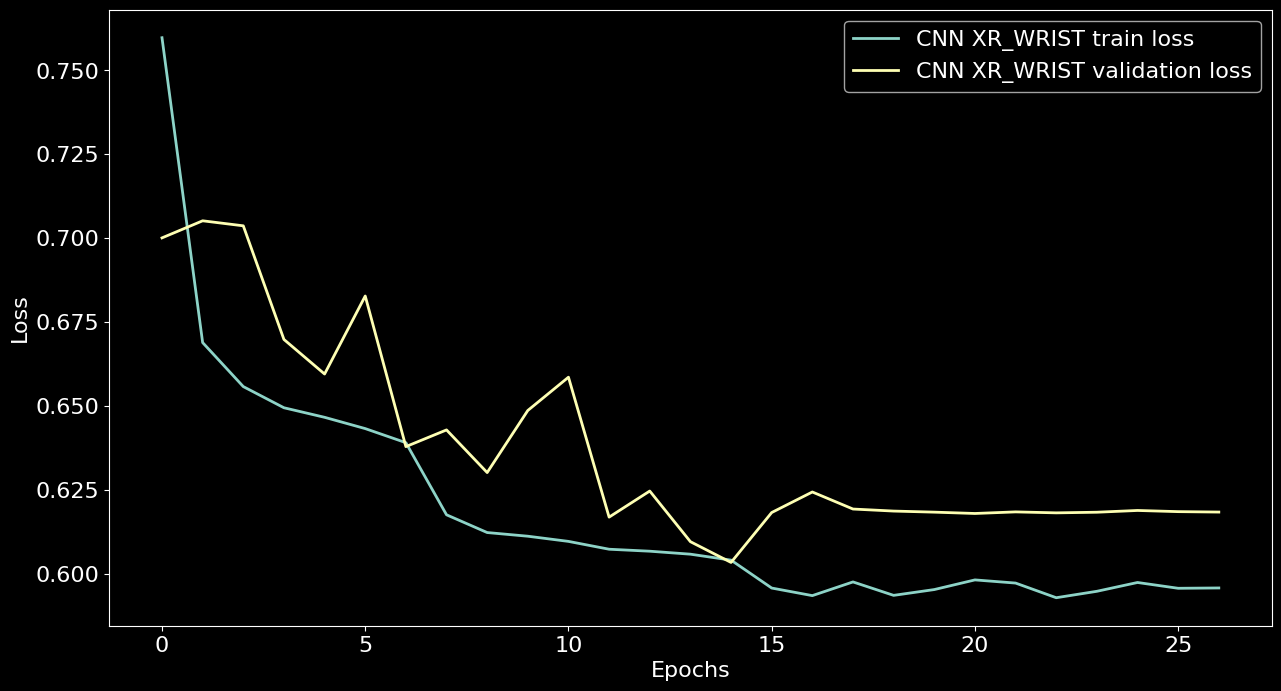

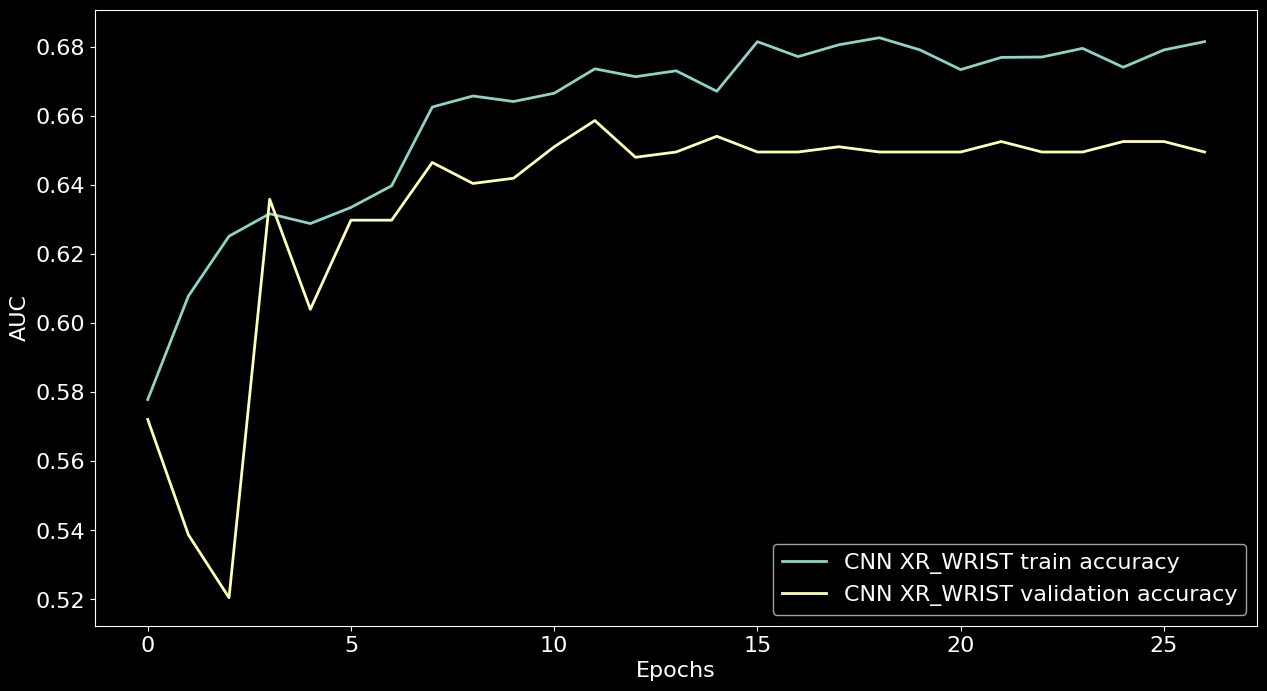

In [ ]:
custom_model_eval=custom_model.evaluate(test_gen,batch_size=200)
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Train Loss     : {0:.5f}".format(custom_model_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(custom_model_eval[1]))
# Plot train and validation error per epoch.
plot_history(hs={'CNN XR_WRIST': history},  metric='loss' )
plot_history(hs={'CNN XR_WRIST': history},  metric='accuracy')

# Utilizing a Pre Trained CNN.(Inception V3)

Create and train a model using a pretrained InceptionV3 with a custom MLP on top. We also use an add gate to connect the result of our first Dense Layer with ou last. It is not Shown in this notebook but the add gate improves the accuracy compared to just stacking MLP Layers.
For the first part we freeze the weights of the Pre trained CNN and train the MLP part for 30 epoch but then we make all layers trainable and we try to train our model for 70 epoch.  

In [ ]:
def train_InceptionV3_mlp(train_generator, validation_generator, input_shape=(320, 320, 3), lr=0.01,
                    mlp_layers=[1024, 1024, 512], activation='relu',  drop_conv=0.2,
                    epochs_upper=30, epochs_lower=70, steps_per_epoch=None, validation_steps=None, verbose=1,checkpoint=None,batch_size=500):
    """
    Create and train a model using a pretrained InceptionV3 with a custom MLP on top.

    """
    # Load InceptionV3 with pretrained weights, excluding the top layer
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape,pooling='avg')
    x = (base_model.output)
    # Freeze the layers of the base_model
    for layer in base_model.layers:
        layer.trainable = False

    for i, units in enumerate(mlp_layers):
        if i==0:
          a= Dense(units=units, activation=activation, name=f'MLP-{i}-{activation}')(x)
        else:
          x = Dense(units=units, activation=activation, name=f'MLP-{i}-{activation}')(x)
    # Add result of the first Dense Layer to the last
    x=Add()([a,x])
    # Add one more Dense Layer
    x = Dense(units=32, activation=activation, name=f'MLP-{i+1}-{activation}')(x)

    # Output layer
    predictions = Dense(1, activation='sigmoid', name=f'MLP-{i+2}-{activation}')(x)

    # Full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=SGD(lr), loss='binary_crossentropy', metrics=['accuracy'])



    # Phase 1: Train only the top layers (custom MLP)
    history_upper = model.fit(train_generator,
                            epochs=epochs_upper,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=validation_generator,
                            validation_steps=validation_steps,
                            verbose=verbose,
                            batch_size=batch_size,
                            callbacks=callbacks())

    # Phase 2: Unfreeze the base VGG19 model layers and continue training
    for layer in base_model.layers:
        layer.trainable = True

    # Re-compile the model (necessary after making layers trainable)
    model.compile(optimizer=Adam(lr*0.1), loss='binary_crossentropy', metrics=['accuracy'])

    history_lower = model.fit(train_generator,
                            epochs=epochs_lower,
                            steps_per_epoch=steps_per_epoch,
                            validation_data=validation_generator,
                            validation_steps=validation_steps,
                            verbose=verbose,
                            batch_size=batch_size,
                            callbacks=callbacks())

    return model, history_upper, history_lower

In [ ]:
dense_model, dense_history_upper, dense_history_lower = train_InceptionV3_mlp(
    train_generator=train_gen,
    validation_generator=val_gen,
    input_shape=(320, 320, 3),
    lr=0.01,
    mlp_layers=[100, 25, 100],
    drop_conv=0.2,
    epochs_upper=30,
    epochs_lower=70,
    steps_per_epoch=train_step_size,
    validation_steps=valid_step_size,
    verbose=1,
    batch_size=320
)

Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.6250
Epoch 1: val_loss improved from inf to 0.63394, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 1233s 4s/step - loss: 0.6472 - accuracy: 0.6250 - val_loss: 0.6339 - val_accuracy: 0.6540 - lr: 0.0100
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6757
Epoch 2: val_loss improved from 0.63394 to 0.59864, saving model to model_checkpoint.h5
275/275 [==============================] - 293s 1s/step - loss: 0.6032 - accuracy: 0.6757 - val_loss: 0.5986 - val_accuracy: 0.6889 - lr: 0.0100
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.6868
Epoch 3: val_loss did not improve from 0.59864
275/275 [==============================] - 292s 1s/step - loss: 0.5888 - accuracy: 0.6868 - val_loss: 0.6036 - val_accuracy: 0.6844 - lr: 0.0100
Epoch 4/30
275/275 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.7008
Epoch 4: val_loss improved from 0.59864 to 0.57754, saving model to model_checkpoint.h5
275/275 [==============================] - 297s 1s/st

In [ ]:
def plot_history_pre_trained(hs, epochs, metric, max_y):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(
            np.arange(hs[label]['x_start'], hs[label]['x_start'] + len(hs[label]['history'].history[metric])),
            hs[label]['history'].history[metric],
            label=f'{label} train {metric}',
            linewidth=2
        )
        plt.plot(
            np.arange(hs[label]['x_start'], hs[label]['x_start'] + len(hs[label]['history'].history[metric])),
            hs[label]['history'].history[f'val_{metric}'],
            label=f'{label} validation {metric}',
            linewidth=2
        )
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks[0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, max_y))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

Using the pre - trained model improved our accuracy by almost 14%.
Training just the upper layers performed as good as our CNN with the self attention layer and the full model even though for a while reduced the accuracy of our model, in the end it resulted in further 13% improvment for the whole model.

31/31 [==============================] - 442s 15s/step - loss: 0.3753 - accuracy: 0.8494
Upper Layers Evaluation:
---
Train Loss     : 0.54351
Validation Loss: 0.57970
---
Train Accuracy     : 0.72675
Validation Accuracy: 0.71168
Full Network Evaluation:
---
Train Loss     : 0.33246
Validation Loss: 0.40380
---
Train Accuracy     : 0.86326
Validation Accuracy: 0.84522

---
Test Loss    : 0.37534
Test Accuracy: 0.84939



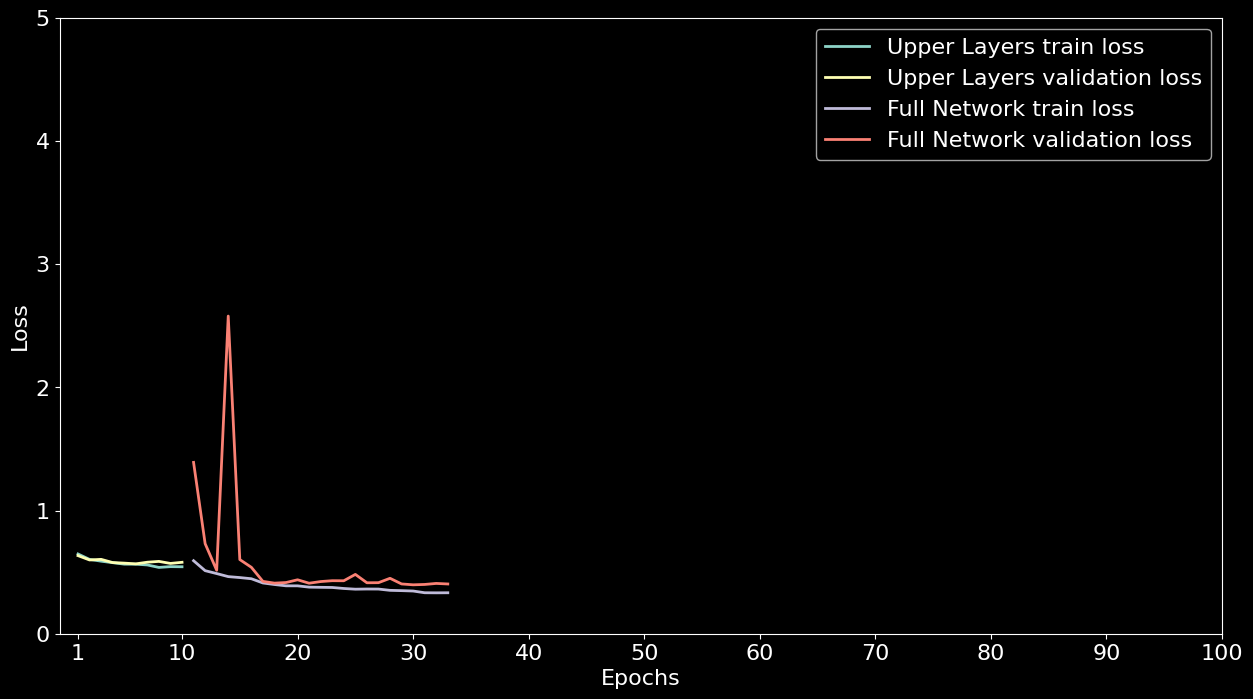

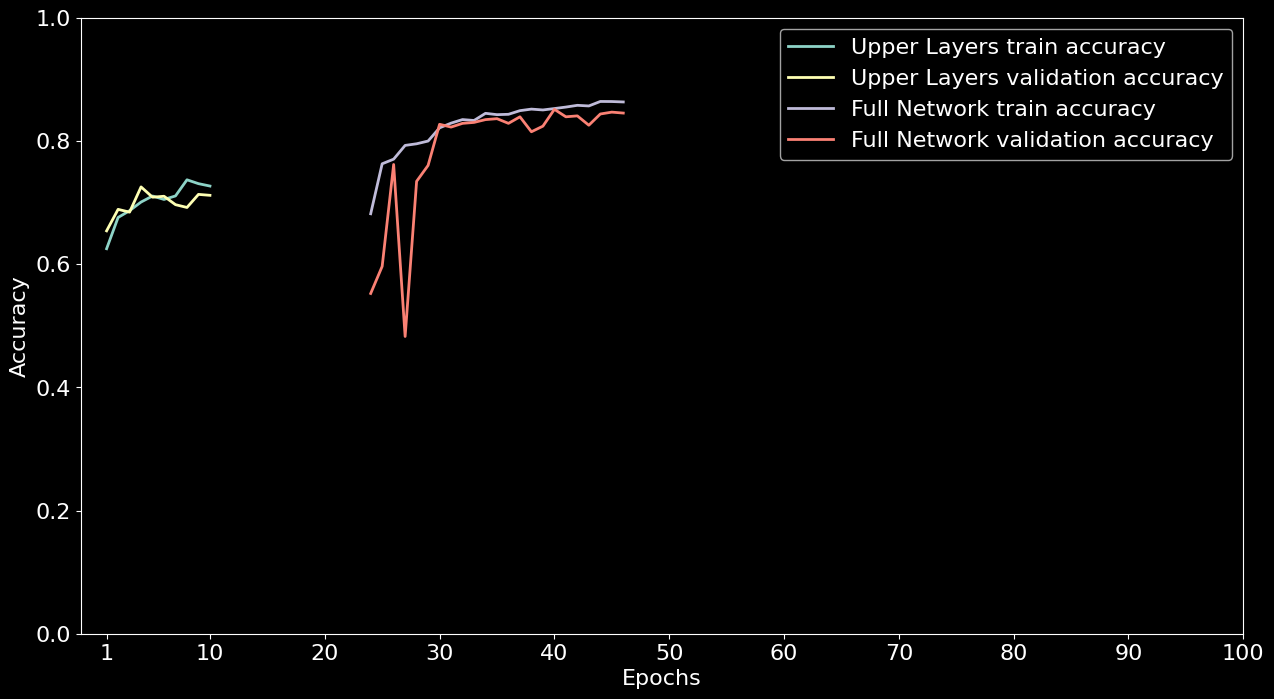

In [ ]:
full_eval = dense_model.evaluate(test_gen, steps=test_step_size)
print("Upper Layers Evaluation:")
print("---")
print("Train Loss     : {0:.5f}".format(dense_history_upper.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(dense_history_upper.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(dense_history_upper.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(dense_history_upper.history['val_accuracy'][-1]))


print("Full Network Evaluation:")
print("---")
print("Train Loss     : {0:.5f}".format(dense_history_lower.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(dense_history_lower.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(dense_history_lower.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(dense_history_lower.history['val_accuracy'][-1]))

print()
print('---')
print("Test Loss    : {0:.5f}".format(full_eval[0]))
print("Test Accuracy: {0:.5f}".format(full_eval[1]))


plot_history_pre_trained(
    hs={
        'Upper Layers': {'history': dense_history_upper, 'x_start': 1},
        'Full Network': {'history': dense_history_lower, 'x_start': len(dense_history_upper.history['loss']) + 1}
    },
    epochs=100,
    metric='loss',
    max_y=5
)
plot_history_pre_trained(
    hs={
        'Upper Layers': {'history': dense_history_upper, 'x_start': 1},
        'Full Network': {'history': dense_history_lower, 'x_start': len(dense_history_lower.history['loss']) + 1}
    },
    epochs=100,
    metric='accuracy',
    max_y=1
)